# Social Network Analysis

## 4. Equivalence Based Role Mining

Task: Grouping users into equivalence classes that define roles
Reference: Doran, D. (2017). Network Role Mining and Analysis. Springer International Publishing, Chapter 3.

In [1]:
%pip install networkx[default]


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [27]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## The Data

The data set is provided by Der Standard, one of the top Austrian newspapers.
In the online Standard people can post comments below articles and up/down vote comments.
The data set used in this handson and further in the project part of the course will consider a sample of those articles, comments, and votes. 

In [3]:
df1 = pd.read_csv('data/Postings_01052019_15052019.csv', sep=';')
df2 = pd.read_csv('data/Postings_16052019_31052019.csv', sep=';')
df = pd.concat([df1, df2], ignore_index=True)
df.head()

,ID_Posting,ID_Posting_Parent,ID_CommunityIdentity,PostingHeadline,PostingComment,PostingCreatedAt,ID_Article,ArticlePublishingDate,ArticleTitle,ArticleChannel,ArticleRessortName,UserCommunityName,UserGender,UserCreatedAt
0,1041073586,1.041073e+09,671476,Das hat gestern bereits der Voggenhuber angefü...,schieder hatte dem inhaltlich nichts entgegenz...,2019-05-01 18:21:15.127,2000102330973,2019-05-01 10:28:57.49,1. Mai in Wien: SPÖ fordert von Strache Rücktritt,Inland,Parteien,Ravenspower,NaN,2018-04-14 13:42:28.470
1,1041073839,1.041073e+09,566938,NaN,...und meinen Bezirk bekommst du als Erbe mit.,2019-05-01 18:28:22.040,2000102330973,2019-05-01 10:28:57.49,1. Mai in Wien: SPÖ fordert von Strache Rücktritt,Inland,Parteien,AlphaRomeo,m,2015-08-28 17:07:41.110
2,1041073872,1.041069e+09,669286,NaN,"Nein, bei der ÖVP/FPÖ genauso passiert. Ich wo...",2019-05-01 18:29:05.533,2000102330973,2019-05-01 10:28:57.49,1. Mai in Wien: SPÖ fordert von Strache Rücktritt,Inland,Parteien,Hpolditsch,NaN,2018-03-06 20:03:42.737
3,1041080734,1.041080e+09,671476,Sie haben doch nichts gefordert??,sie haben nur die regierung kritisiert. das di...,2019-05-01 22:37:56.010,2000102330973,2019-05-01 10:28:57.49,1. Mai in Wien: SPÖ fordert von Strache Rücktritt,Inland,Parteien,Ravenspower,NaN,2018-04-14 13:42:28.470
4,1041080828,NaN,671476,Heute wäre der perfekte Tag für die SPÖ gewese...,"ihr noch nicht erfülltes versprechen, den silb...",2019-05-01 22:42:06.310,2000102330973,2019-05-01 10:28:57.49,1. Mai in Wien: SPÖ fordert von Strache Rücktritt,Inland,Parteien,Ravenspower,NaN,2018-04-14 13:42:28.470


There are different entities in the data set: 
* Users - identified by *ID_CommunityIdentity* (or *UserCommunityName*)
* Postings - identified by *ID_Posting*
* Articles - identified by *ID_Article*

Thus, there are different possibilities to build networks based on the posting data. 
We will concentrate now on the ***reply-to-network***. 


In [15]:
votes1 = pd.read_csv('./data/Votes_01052019_15052019.csv', sep=';')
votes2 = pd.read_csv('./data/Votes_16052019_31052019.csv', sep=';')
votes = pd.concat([votes1, votes2], ignore_index=True)
votes.head()

,ID_CommunityIdentity,ID_Posting,VoteNegative,VotePositive,VoteCreatedAt,UserCommunityName,UserGender,UserCreatedAt
0,675862,1041076570,1,0,2019-05-06 16:47:46.883,Heckscheibenwischer,m,2018-06-26 06:04:30.513
1,689023,1041076570,1,0,2019-05-01 22:19:06.240,Heinz Fettleber,NaN,2019-03-08 21:23:11.463
2,24810,1041076745,0,1,2019-05-01 23:54:54.600,Bruce Campbell,m,2011-01-12 16:50:40.597
3,673781,1041076745,0,1,2019-05-01 20:59:29.910,Erdäpfelsack,NaN,2018-05-29 07:13:49.350
4,24810,1041076831,0,1,2019-05-01 23:51:42.730,Bruce Campbell,m,2011-01-12 16:50:40.597


In [16]:
votes_sample = votes[:1000]
votes_sample.to_csv('./data/votes_sample.csv', sep=',')

df_sample = df[:1000]
df_sample.to_csv('./data/df_sample.csv', sep=',')

In [5]:
votes['UserGender'].value_counts()

UserGender
m    976927
w    235664
Name: count, dtype: int64

In [21]:
merged_data = pd.merge(df, votes, on='ID_Posting')

# Dropping any duplicate columns that might have been created due to the merge
merged_data = merged_data.loc[:,~merged_data.columns.duplicated()]
merged_data.head()

,ID_Posting,ID_Posting_Parent,ID_CommunityIdentity_x,PostingHeadline,PostingComment,PostingCreatedAt,ID_Article,ArticlePublishingDate,ArticleTitle,ArticleChannel,...,UserCommunityName_x,UserGender_x,UserCreatedAt_x,ID_CommunityIdentity_y,VoteNegative,VotePositive,VoteCreatedAt,UserCommunityName_y,UserGender_y,UserCreatedAt_y
0,1041073586,1.041073e+09,671476,Das hat gestern bereits der Voggenhuber angefü...,schieder hatte dem inhaltlich nichts entgegenz...,2019-05-01 18:21:15.127,2000102330973,2019-05-01 10:28:57.49,1. Mai in Wien: SPÖ fordert von Strache Rücktritt,Inland,...,Ravenspower,NaN,2018-04-14 13:42:28.470,572203,0,1,2019-05-01 18:46:37.437,Hollerbusch,w,2015-11-15 22:08:58.497
1,1041073586,1.041073e+09,671476,Das hat gestern bereits der Voggenhuber angefü...,schieder hatte dem inhaltlich nichts entgegenz...,2019-05-01 18:21:15.127,2000102330973,2019-05-01 10:28:57.49,1. Mai in Wien: SPÖ fordert von Strache Rücktritt,Inland,...,Ravenspower,NaN,2018-04-14 13:42:28.470,206222,0,1,2019-05-01 18:38:54.227,Talerkogel,m,2001-09-28 11:54:33.000
2,1041073586,1.041073e+09,671476,Das hat gestern bereits der Voggenhuber angefü...,schieder hatte dem inhaltlich nichts entgegenz...,2019-05-01 18:21:15.127,2000102330973,2019-05-01 10:28:57.49,1. Mai in Wien: SPÖ fordert von Strache Rücktritt,Inland,...,Ravenspower,NaN,2018-04-14 13:42:28.470,212488,0,1,2019-05-01 22:43:43.030,Chucho,m,2011-02-15 16:39:55.250
3,1041080734,1.041080e+09,671476,Sie haben doch nichts gefordert??,sie haben nur die regierung kritisiert. das di...,2019-05-01 22:37:56.010,2000102330973,2019-05-01 10:28:57.49,1. Mai in Wien: SPÖ fordert von Strache Rücktritt,Inland,...,Ravenspower,NaN,2018-04-14 13:42:28.470,581206,0,1,2019-05-01 23:31:04.717,wertekonservativ,m,2016-05-03 01:26:10.280
4,1041080734,1.041080e+09,671476,Sie haben doch nichts gefordert??,sie haben nur die regierung kritisiert. das di...,2019-05-01 22:37:56.010,2000102330973,2019-05-01 10:28:57.49,1. Mai in Wien: SPÖ fordert von Strache Rücktritt,Inland,...,Ravenspower,NaN,2018-04-14 13:42:28.470,25580,0,1,2019-05-01 23:30:32.150,CEEIT,m,2006-04-30 20:57:45.160


In [8]:
merged_data[:1000].to_csv('./data/merged_df.csv', sep=';')

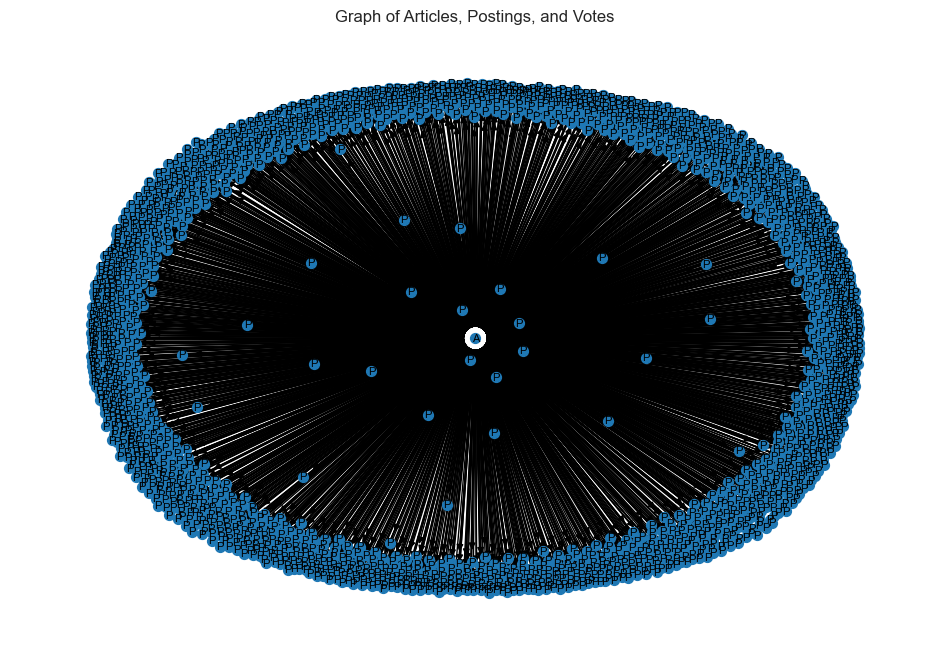

In [22]:
# data = merged_df[:1000]
data = merged_data[merged_data['ID_Article'] == 2000102330973]

graph_data = data[['ID_Article', 'ArticleTitle', 'ArticleChannel', 'ArticleRessortName', 'ID_Posting', 'PostingComment', 'VotePositive', 'VoteNegative']]

# Create a graph object
G = nx.DiGraph()

# Adding nodes and edges for Articles, Article Channels, and Ressorts
for _, row in graph_data.iterrows():
    # Add nodes
    G.add_node(row['ID_Article'], type='Article', title=row['ArticleTitle'], channel=row['ArticleChannel'], ressort=row['ArticleRessortName'])
    G.add_node(row['ID_Posting'], type='Posting', comment=row['PostingComment'])

    # Add edges
    # Article to Posting
    G.add_edge(row['ID_Article'], row['ID_Posting'], weight=1)

# Adding weights for votes to the Posting nodes
for node in G.nodes(data=True):
    if node[1]['type'] == 'Posting':
        posting_row = graph_data[graph_data['ID_Posting'] == node[0]].iloc[0]
        vote_weight = posting_row['VotePositive'] - posting_row['VoteNegative']
        G.nodes[node[0]]['vote_weight'] = vote_weight

# Visualizing the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # positions for all nodes

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=50)
nx.draw_networkx_edges(G, pos, width=1)

# Draw node labels
node_labels = {node[0]: node[1]['type'][0] for node in G.nodes(data=True)}  # Just first letter of type for simplicity
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

plt.title('Graph of Articles, Postings, and Votes')
plt.axis('off')
plt.show()

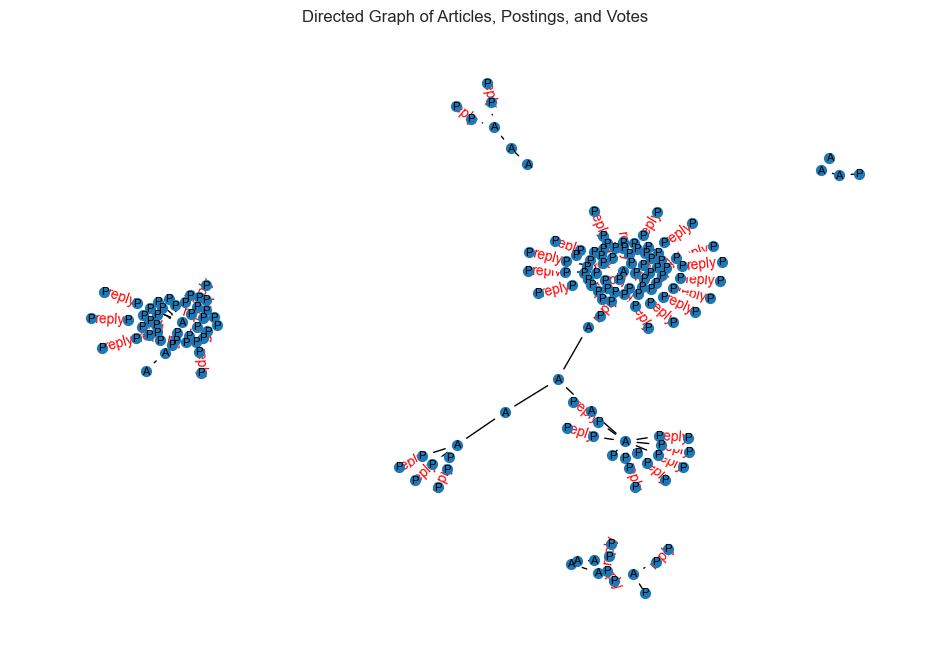

(NodeDataView({'Inland': {'type': 'ArticleChannel'}, 'Parteien': {'type': 'ArticleRessortName'}, 2000102330973: {'type': 'Article'}, 1041073586: {'type': 'Posting', 'vote_weight': 1}, 1041073234.0: {'type': 'Parent Posting'}, 1041080734: {'type': 'Posting', 'vote_weight': 1}, 1041080236.0: {'type': 'Parent Posting'}, 1041080828: {'type': 'Posting', 'vote_weight': 1}, 1041080938: {'type': 'Posting', 'vote_weight': 1}, 1041080782.0: {'type': 'Parent Posting'}, 1041073564: {'type': 'Posting', 'vote_weight': 1}, 1041073412.0: {'type': 'Parent Posting'}, 1041073653: {'type': 'Posting', 'vote_weight': -1}, 1041072539.0: {'type': 'Parent Posting'}, 1041073991: {'type': 'Posting', 'vote_weight': 1}, 1041074052: {'type': 'Posting', 'vote_weight': -1}, 1041073206.0: {'type': 'Parent Posting'}, 1041074142: {'type': 'Posting', 'vote_weight': 1}, 1041073075.0: {'type': 'Parent Posting'}, 1041080903: {'type': 'Posting', 'vote_weight': -1}, 'Sachpolitik': {'type': 'ArticleRessortName'}, 2000102386715

In [45]:
# data = merged_data[merged_data['ID_Article'] == 2000102330973]
data = merged_data[:1000]

graph_data = data[['ArticleChannel', 'ArticleRessortName', 'ID_Article', 'ID_Posting', 'ID_Posting_Parent', 'VotePositive', 'VoteNegative']]


G_directed = nx.Graph()

for _, row in graph_data.iterrows():
    # Add nodes for ArticleChannel, ArticleRessortName, Article, Posting, and Parent Posting (if exists)
    G_directed.add_node(row['ArticleChannel'], type='ArticleChannel')
    G_directed.add_node(row['ArticleRessortName'], type='ArticleRessortName')
    G_directed.add_node(row['ID_Article'], type='Article')
    G_directed.add_node(row['ID_Posting'], type='Posting')
    if not pd.isna(row['ID_Posting_Parent']):
        G_directed.add_node(row['ID_Posting_Parent'], type='Parent Posting')

    # Add directed edges
    G_directed.add_edge(row['ArticleChannel'], row['ArticleRessortName'], weight=1)
    G_directed.add_edge(row['ArticleRessortName'], row['ID_Article'], weight=1)
    G_directed.add_edge(row['ID_Article'], row['ID_Posting'], weight=1)
    if not pd.isna(row['ID_Posting_Parent']):
        G_directed.add_edge(row['ID_Posting_Parent'], row['ID_Posting'], weight=1, label='reply')

# Adding weights for votes to the Posting nodes
for node in G_directed.nodes(data=True):
    if node[1]['type'] == 'Posting':
        posting_row = graph_data[graph_data['ID_Posting'] == node[0]].iloc[0]
        vote_weight = posting_row['VotePositive'] - posting_row['VoteNegative']
        G_directed.nodes[node[0]]['vote_weight'] = vote_weight

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_directed)

nx.draw_networkx_nodes(G_directed, pos, node_size=50)
nx.draw_networkx_edges(G_directed, pos, width=1, arrows=True)

node_labels = {node[0]: node[1]['type'][0] for node in G_directed.nodes(data=True)}  # Just first letter of type for simplicity
nx.draw_networkx_labels(G_directed, pos, labels=node_labels, font_size=8)

edge_labels = nx.get_edge_attributes(G_directed, 'label')
nx.draw_networkx_edge_labels(G_directed, pos, edge_labels=edge_labels, font_color='red')

plt.title('Directed Graph of Articles, Postings, and Votes')
plt.axis('off')
plt.show()

G_directed.nodes(data=True), G_directed.edges(data=True)

In [29]:
def find_structural_equivalent_nodes(graph):
    structural_equivalent = []
    nodes = list(graph.nodes())
    while nodes:
        node = nodes[0]
        equivalent = [node]
        neighbors = set(graph.neighbors(node))
        nodes.remove(node)
        i = 0
        while i < len(equivalent):
            curr_node = equivalent[i]
            for n in nodes[:]:
                if neighbors == set(graph.neighbors(n)):
                    equivalent.append(n)
                    nodes.remove(n)
            i += 1
        if len(equivalent) > 1:
            structural_equivalent.append(equivalent)
    return structural_equivalent

def find_common_neighbor_equivalent_nodes(graph):
    common_neighbor_equivalent = []
    nodes = list(graph.nodes())
    while nodes:
        node = nodes[0]
        equivalent = [node]
        neighbors = set(graph.neighbors(node))
        nodes.remove(node)
        i = 0
        while i < len(equivalent):
            curr_node = equivalent[i]
            curr_neighbors = set(graph.neighbors(curr_node))
            for n in nodes[:]:
                if len(curr_neighbors.intersection(set(graph.neighbors(n)))) == len(neighbors):
                    equivalent.append(n)
                    nodes.remove(n)
            i += 1
        if len(equivalent) > 1:
            common_neighbor_equivalent.append(equivalent)
    return common_neighbor_equivalent

def find_edge_equivalent_nodes(graph):
    edge_equivalent = []
    edges = list(graph.edges())
    while edges:
        edge = edges[0]
        equivalent = [edge]
        nodes = set(edge)
        edges.remove(edge)
        i = 0
        while i < len(equivalent):
            curr_edge = equivalent[i]
            for e in edges[:]:
                if set(e).intersection(nodes) == nodes:
                    equivalent.append(e)
                    nodes.update(e)
                    edges.remove(e)
            i += 1
        if len(equivalent) > 1:
            edge_equivalent.append(equivalent)
    return edge_equivalent

In [30]:
def equivalence_pipeline(graph):
    equivalence_functions = [
        find_structural_equivalent_nodes,
        find_common_neighbor_equivalent_nodes,
        find_edge_equivalent_nodes
    ]

    all_groups = []

    for func in equivalence_functions:
        equivalent_nodes = func(graph)
        all_groups.extend(equivalent_nodes)

    
    num_groups = len(all_groups)

    new_colors = plt.cm.tab10.colors + plt.cm.Set3.colors + plt.cm.Paired.colors
    new_colors = new_colors[:num_groups]
    new_colormap = mcolors.ListedColormap(new_colors)

    for func in equivalence_functions:
        equivalent_nodes = func(graph)
        
        color_map = {}
        for i, nodes in enumerate(equivalent_nodes):
            for node in nodes:
                color_map[node] = i

        default_color = len(equivalent_nodes)
        for node in graph.nodes():
            if node not in color_map:
                color_map[node] = default_color

        pos = nx.spring_layout(graph, seed=23768)

        plt.figure(figsize=(42, 42))
        node_colors = [color_map[node] for node in graph.nodes()]
        nx.draw(graph, pos, node_color=node_colors, with_labels=False, cmap=new_colormap)
        plt.show()

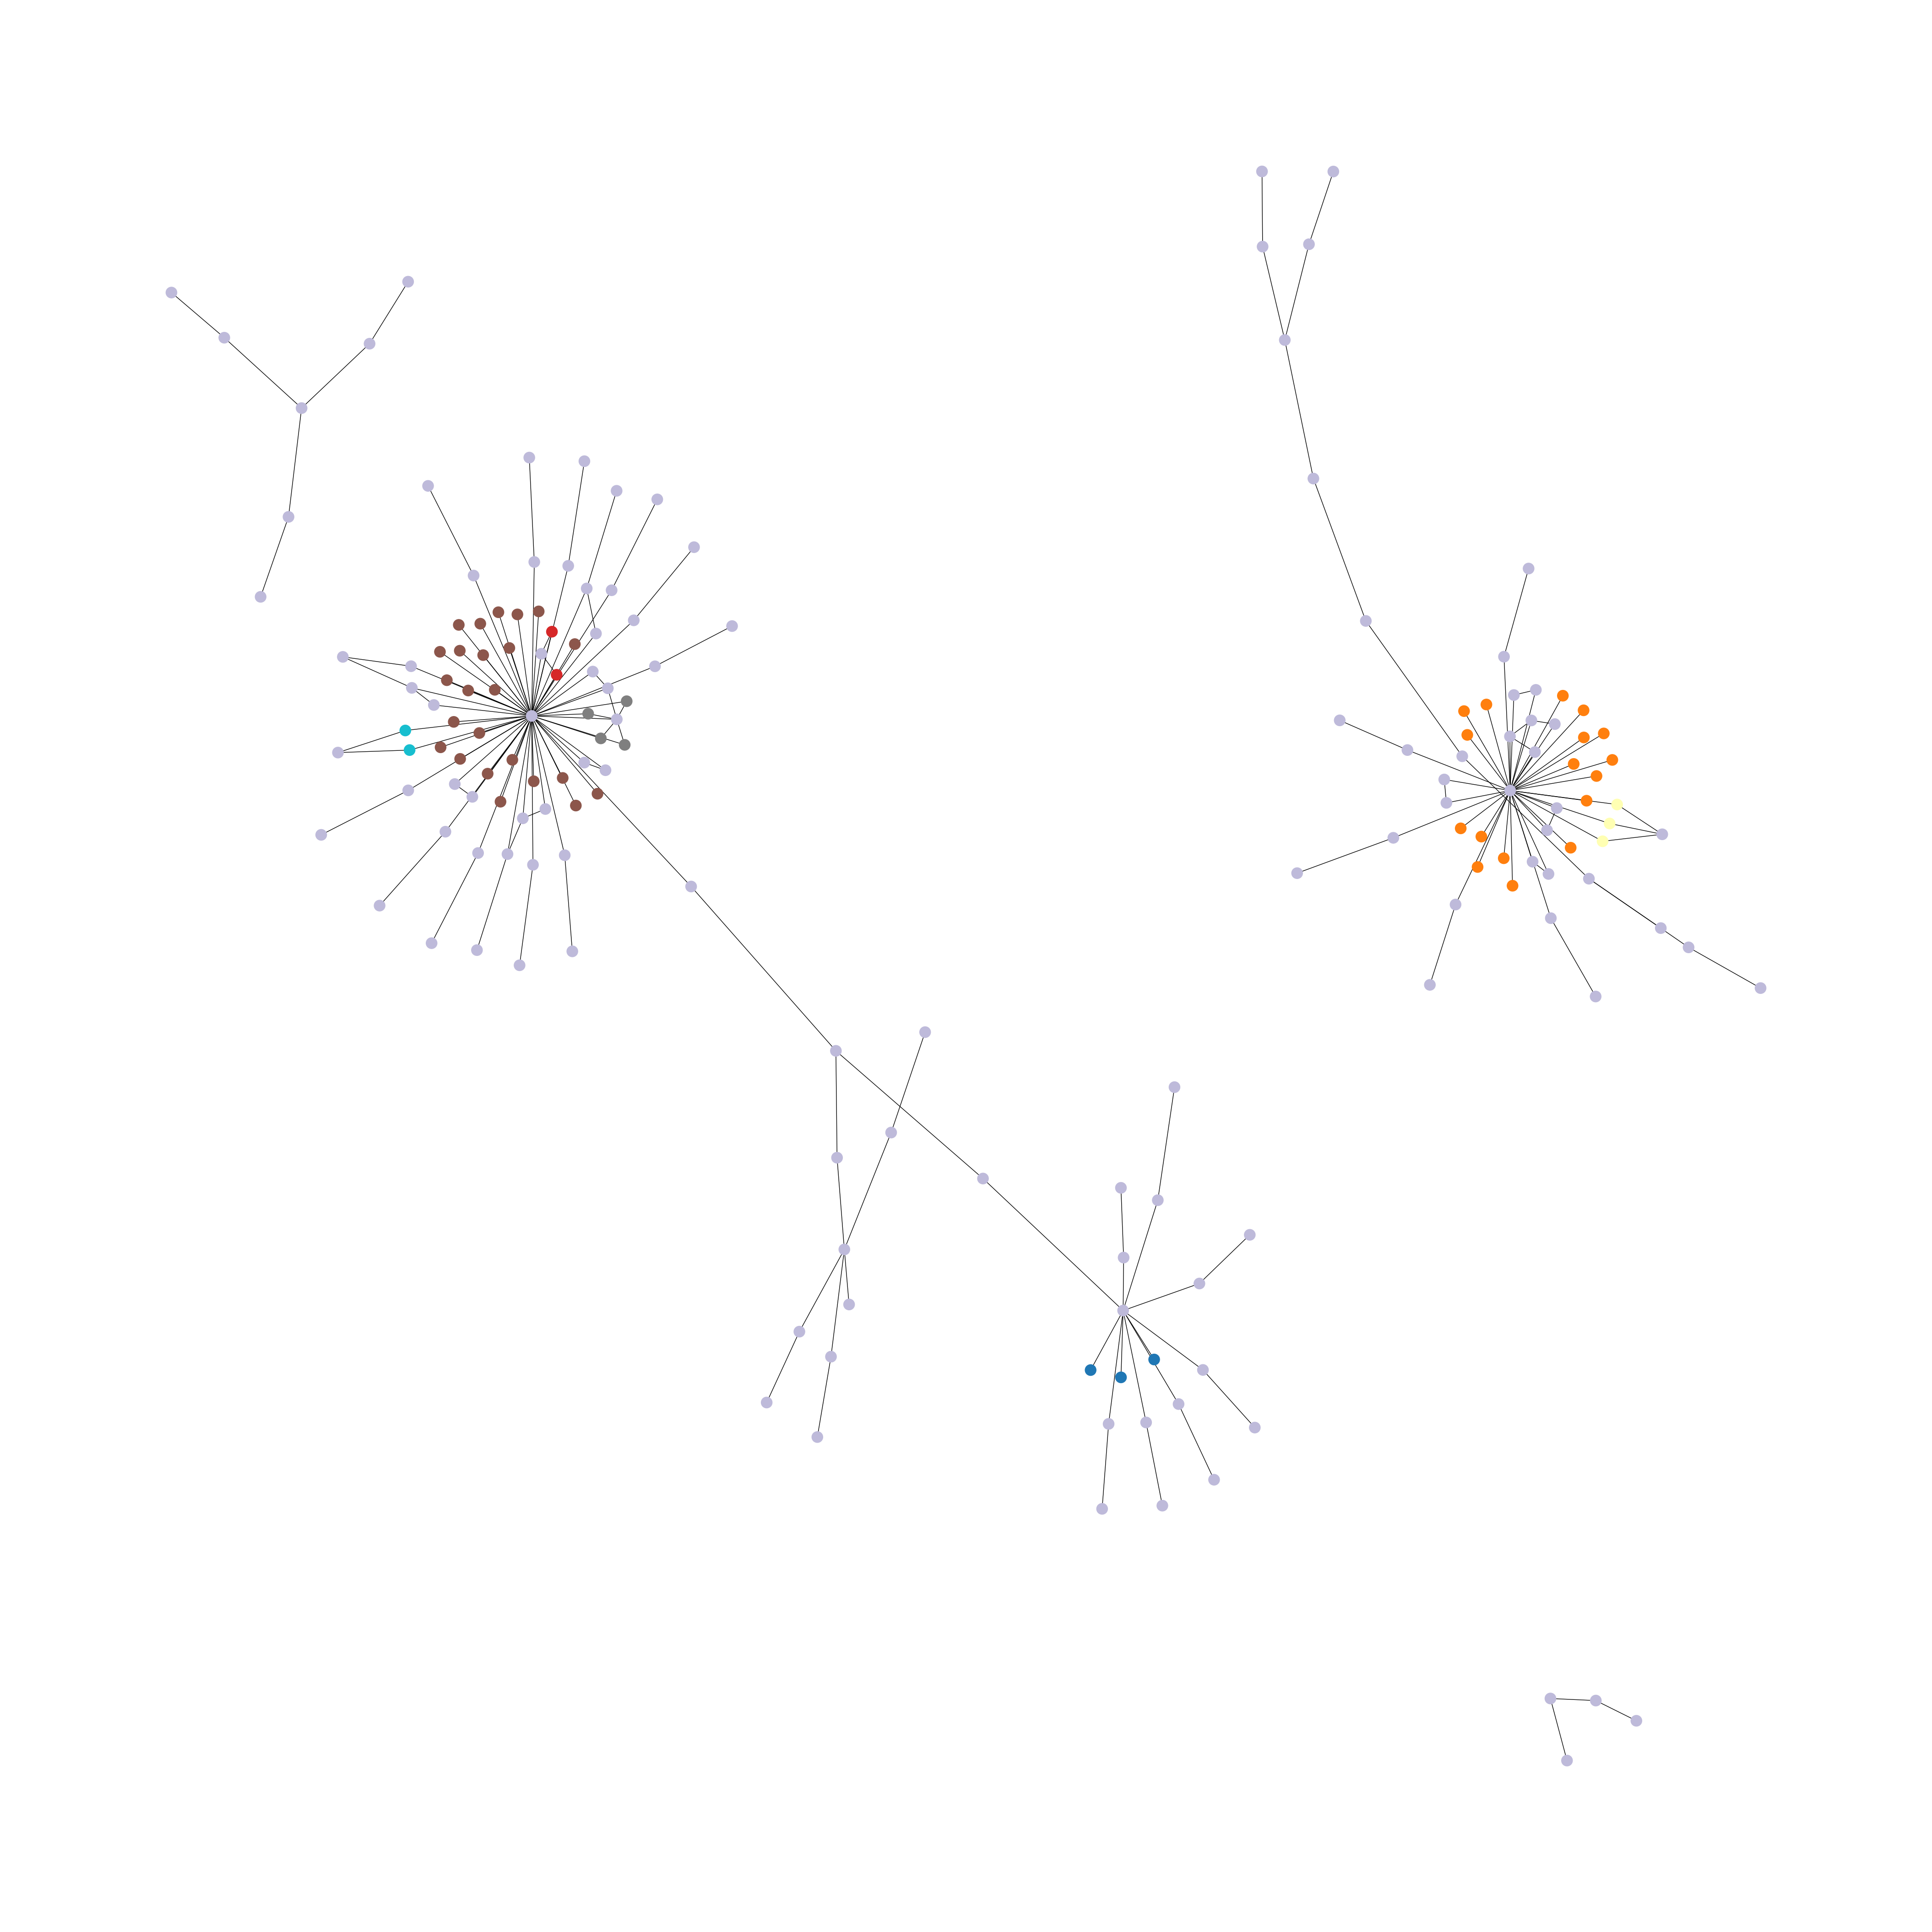

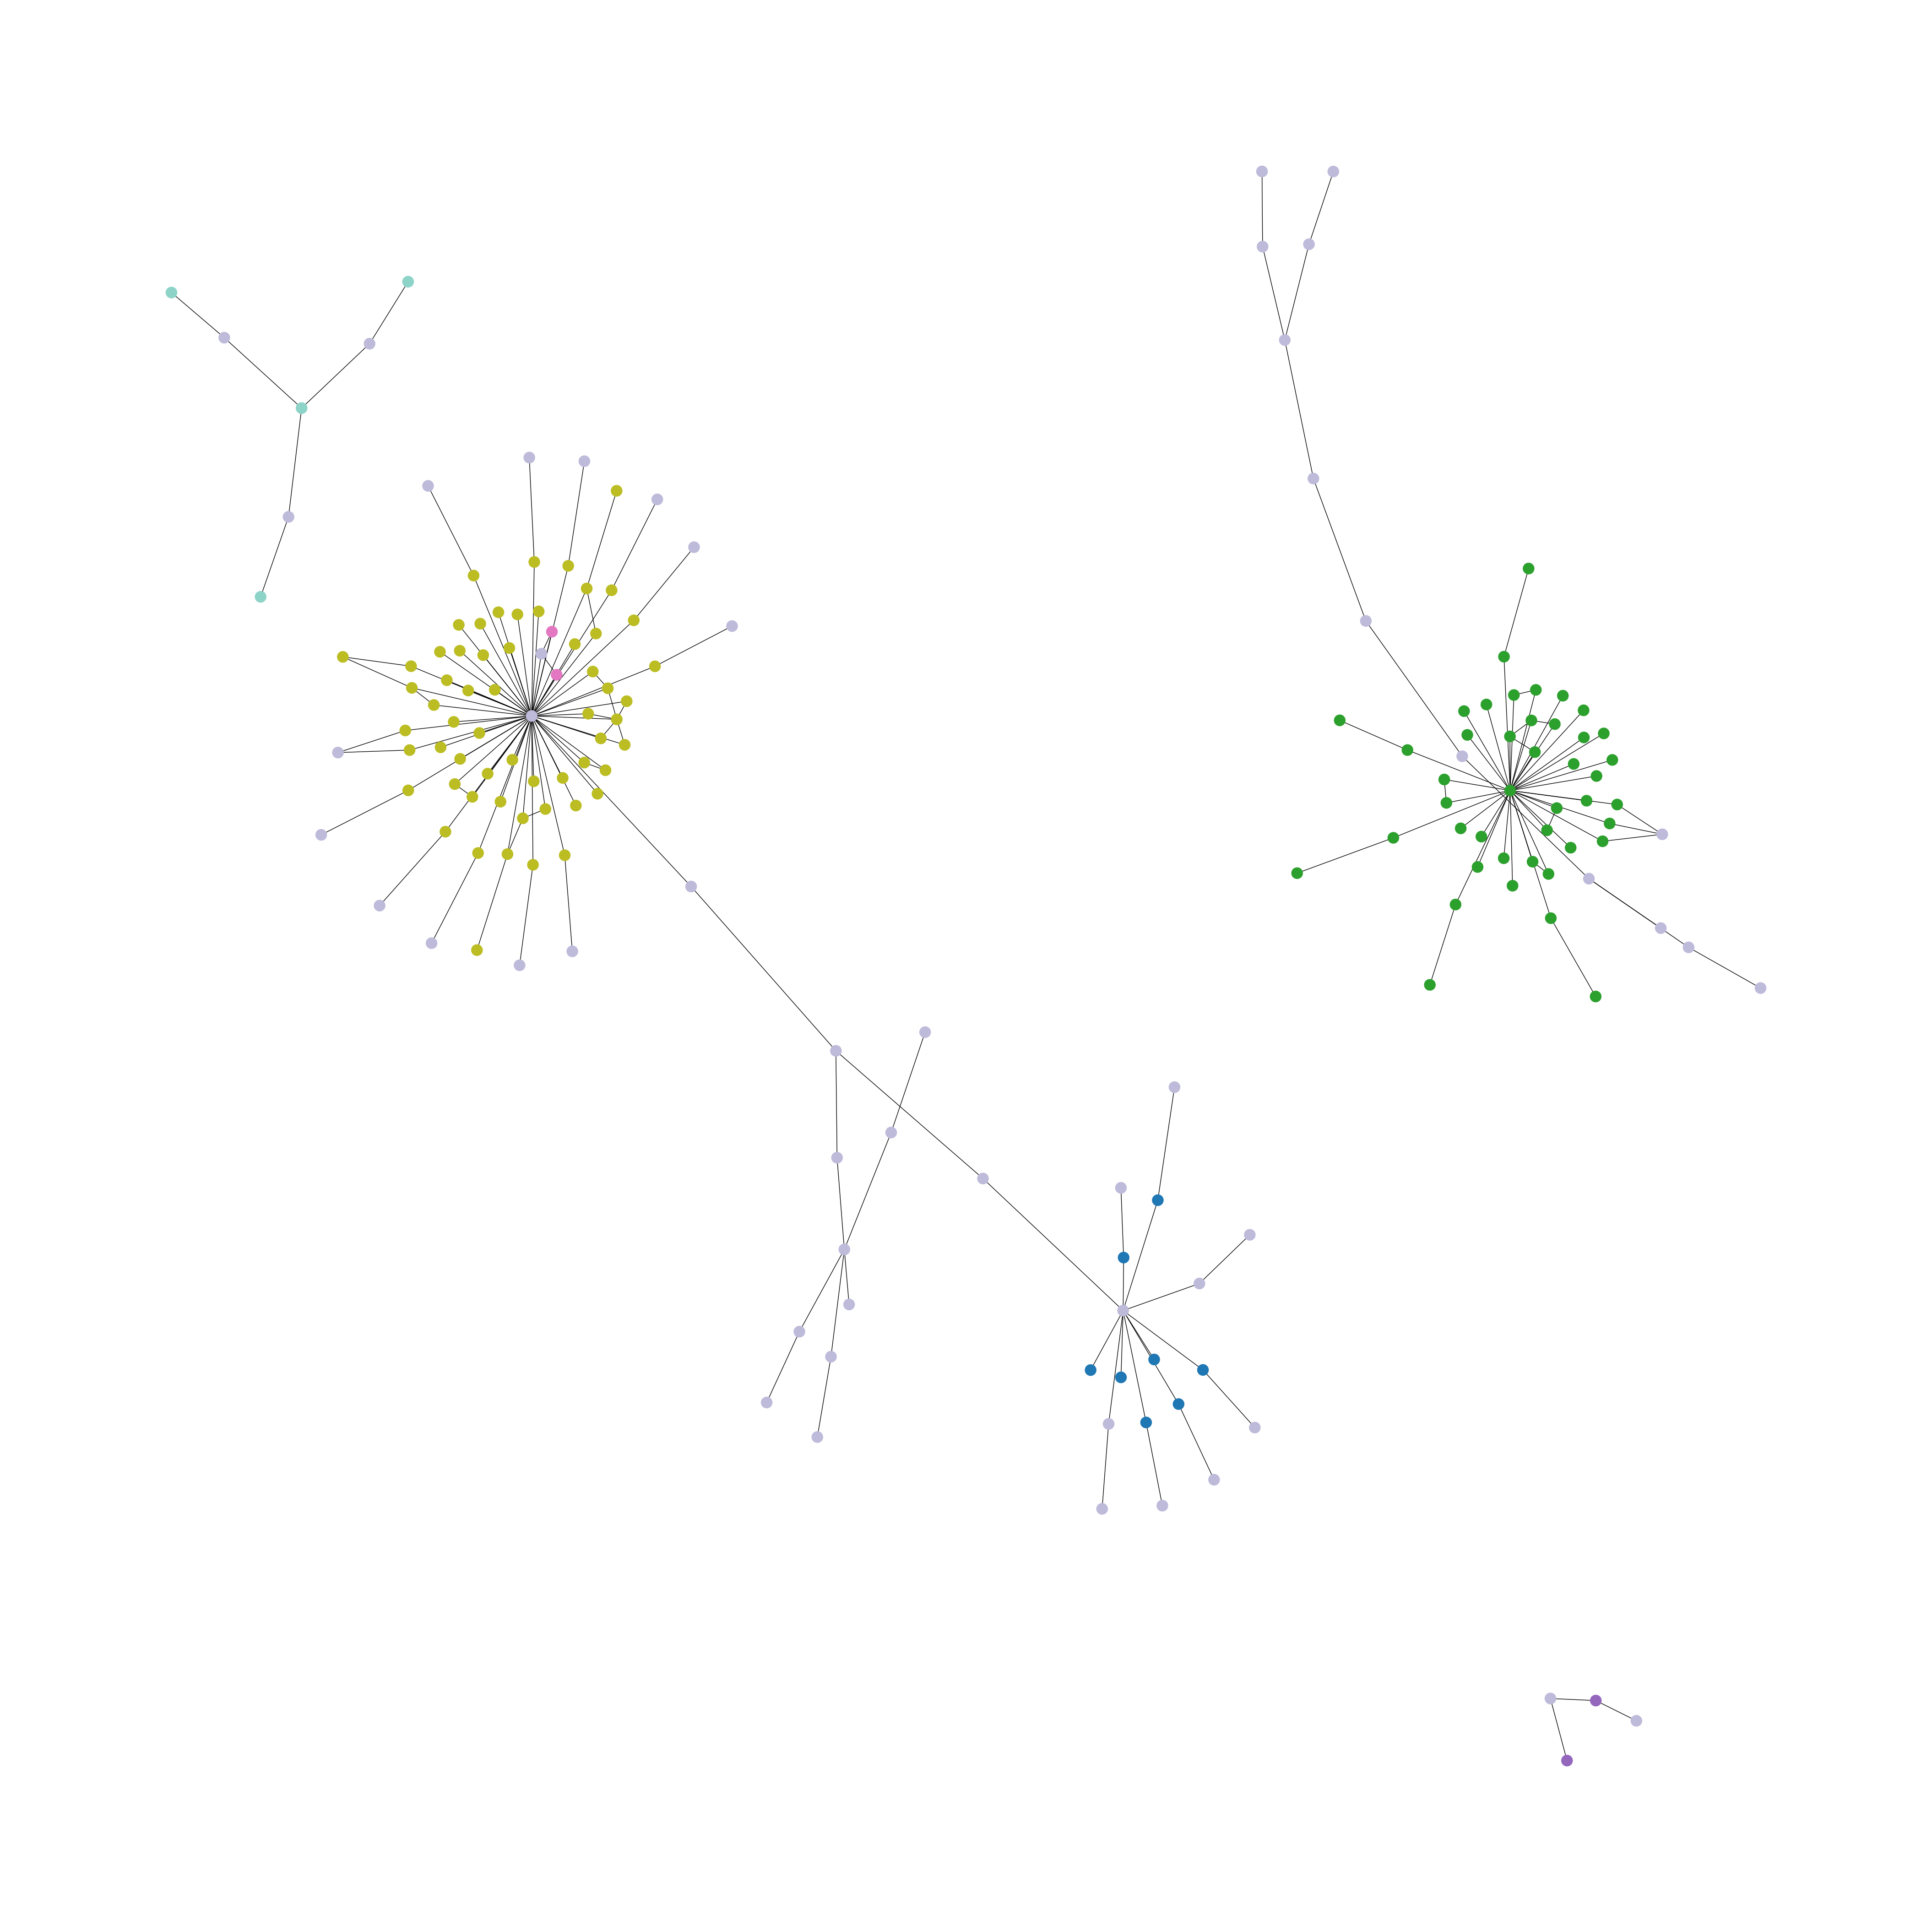

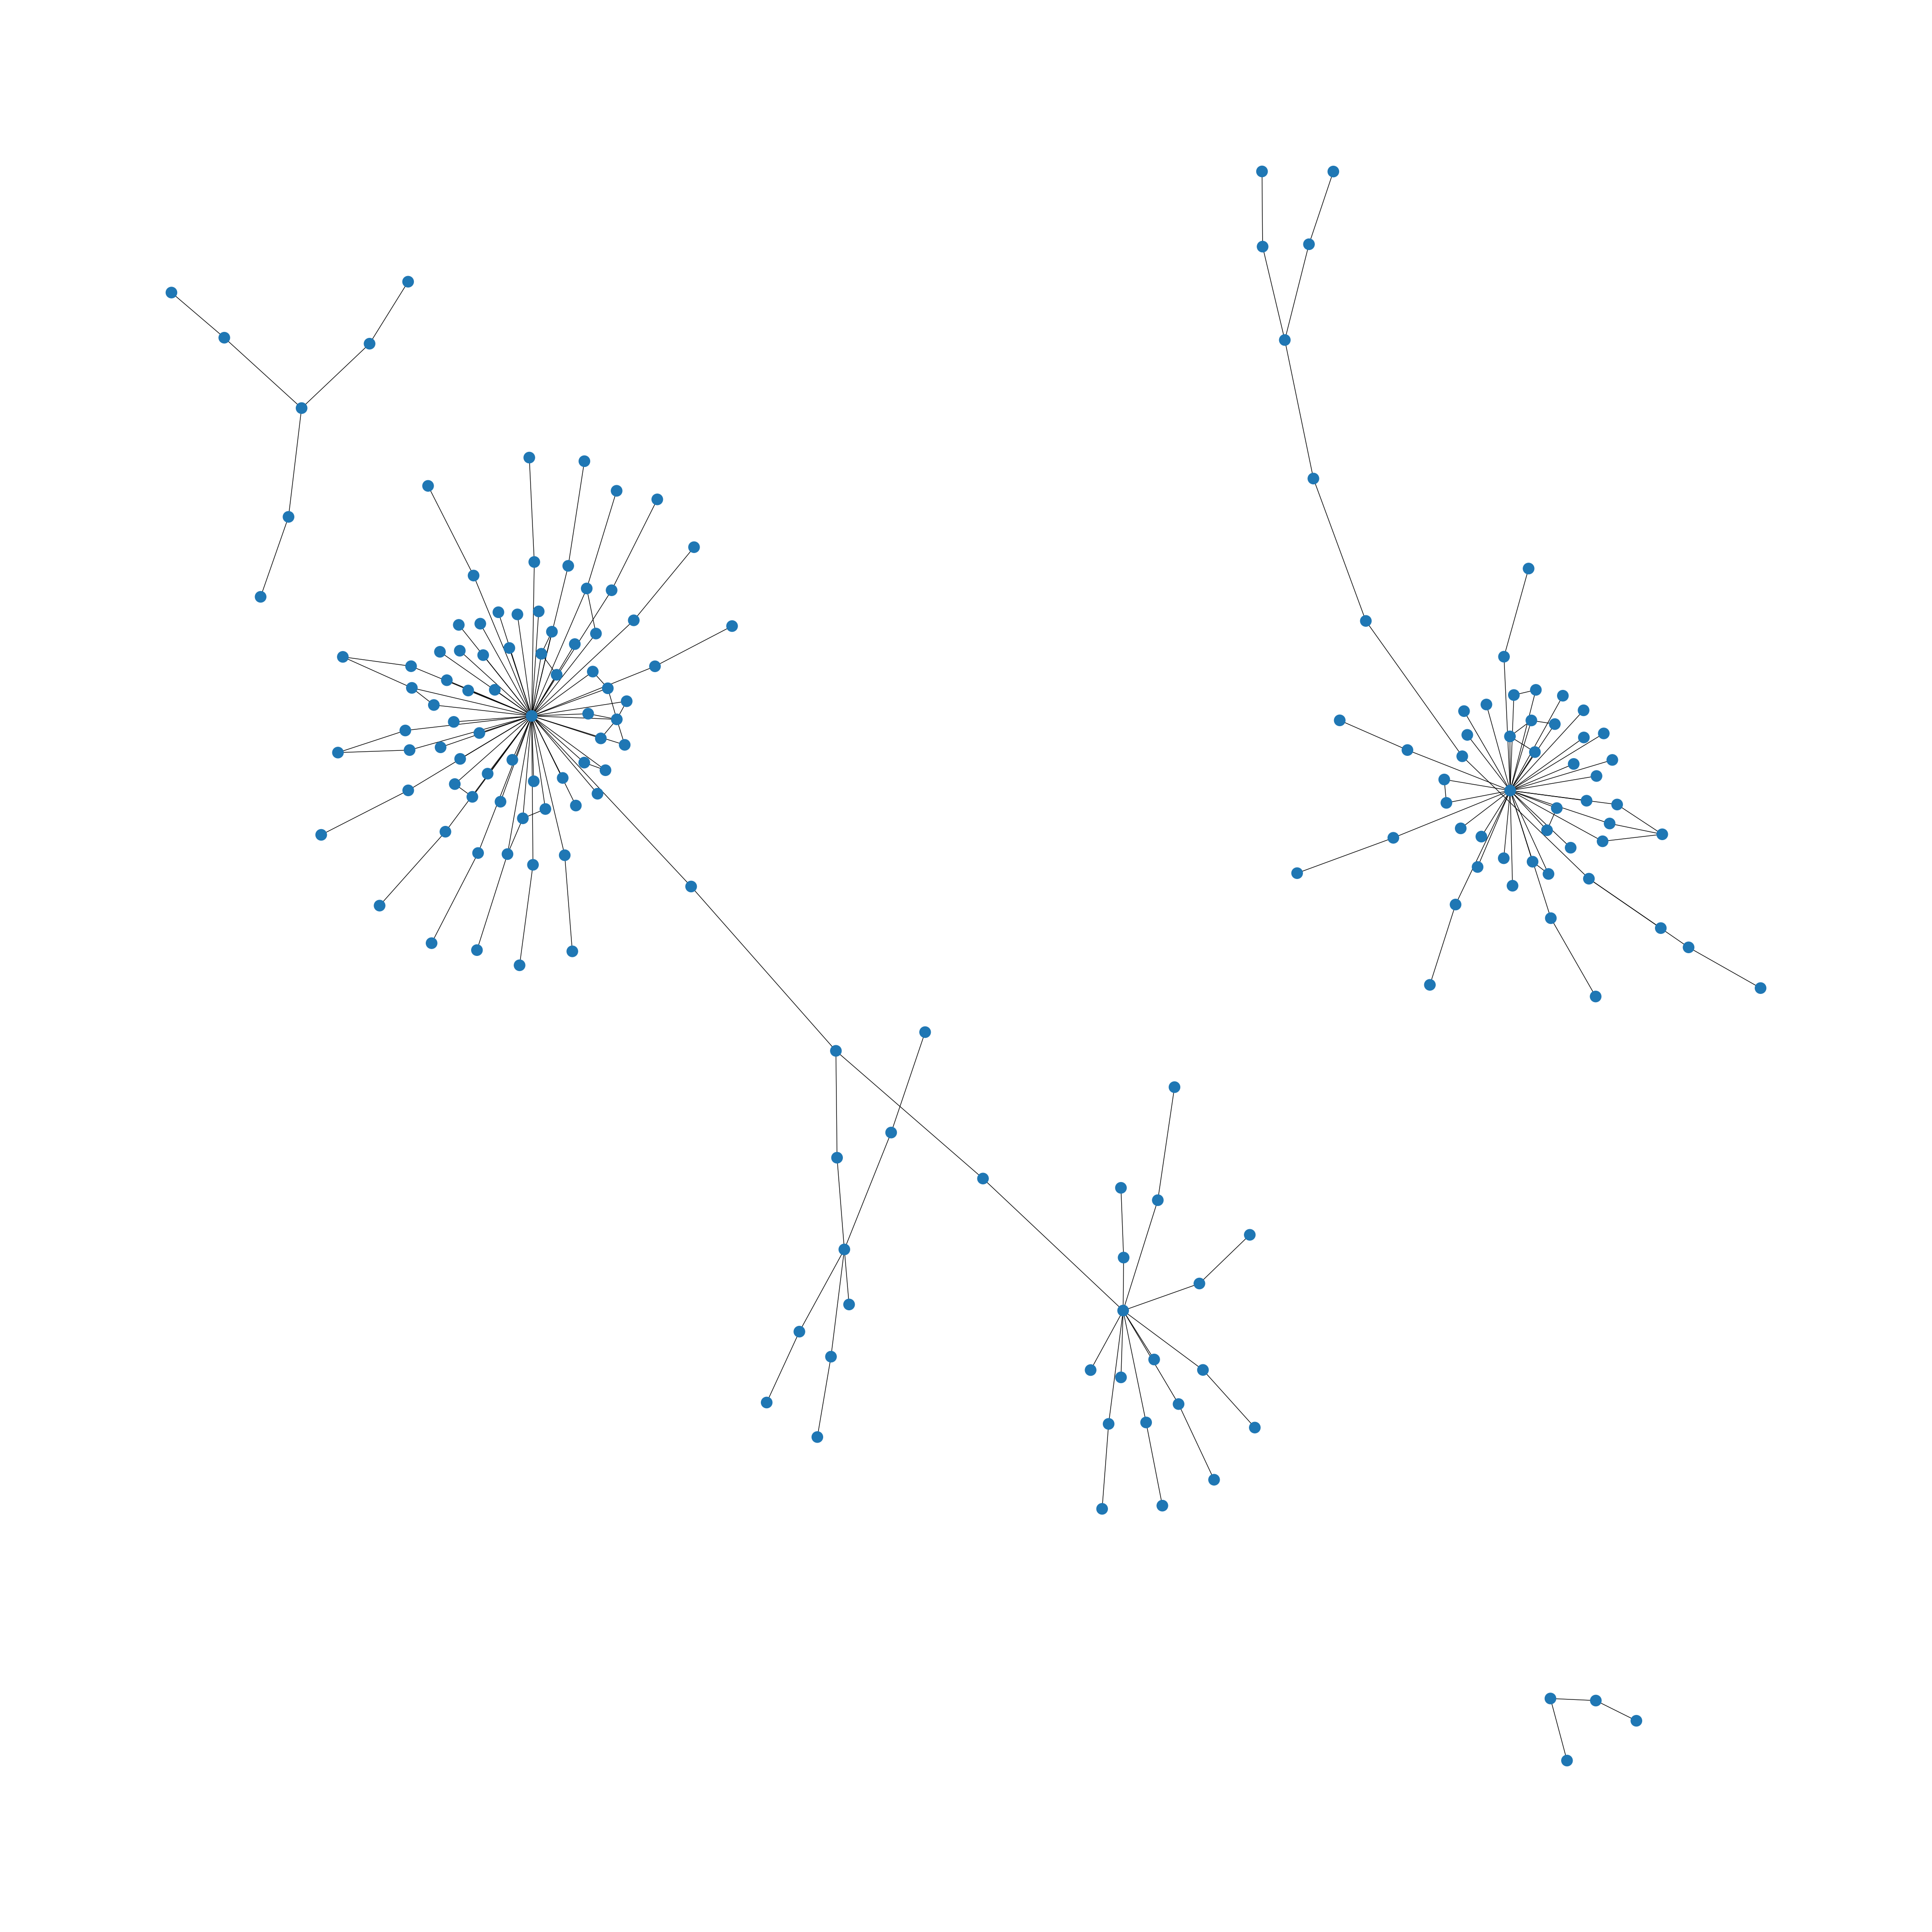

In [46]:
equivalence_pipeline(G_directed)

In [43]:
from pyvis.network import Network

# Create an interactive network graph using pyvis
net = Network(notebook=True, directed=True, height="750px", width="100%")

# Add nodes to the network
for node, attr in G_directed.nodes(data=True):
    node_str = str(node)  # Convert node identifier to string
    title = f"{attr['type']}: {node_str}"
    net.add_node(node_str, title=title, label=node_str, group=attr['type'])

# Add edges to the network, ensuring all nodes exist
for u, v, attr in G_directed.edges(data=True):
    u_str, v_str = str(u), str(v)  # Convert edge node identifiers to strings
    if u_str in net.get_nodes() and v_str in net.get_nodes():
        label = attr.get('label', '')  # Use get method to avoid KeyError
        title = label if label else "Posted in response to" if u_str != v_str else "Posted in"
        net.add_edge(u_str, v_str, title=title, width=2 if label else 1)

# Set options for better visualization
net.set_options("""
{
  "nodes": {
    "font": {
      "size": 12
    }
  },
  "edges": {
    "color": {
      "inherit": true
    },
    "smooth": false
  },
  "physics": {
    "enabled": false
  }
}
""")

net.save_graph("graph.html")
net.show("graph.html")

graph.html
